# Multinomial Logistic Regression from scratch

In statistics, **multinomial logistic regression** is a classification method that generalizes logistic regression to multiclass problems, i.e. with more than two possible discrete outcomes where one sample could belong only to one class.


The whole model, including the activation function can be written as:
$$\hat{y} = softmax(xW+b)$$

This model is sometimes called multiclass logistic regression. Other common names for it include _softmax regression_ and _multinomial regression_.

__What does the model actually do?__

* **First:** it transforms the input vector $x$ of size `input_features_number` to the new vector $z$ of size `number_of_classes`.
* **Second:** it applies softmax over the output vector $z$ to make its components look like probabilities.

In other words, given an **input vector x**, model computes new vector $z = Wx+b$. Then softmax does two things. First, it exponentiates (elementwise) $e^z$, forcing all values to be strictly positive. Then it normalizes so that all values sum to 1. The softmax operation computes the following:
$$softmax(z) = \frac{e^{z}}{\sum_{i=1}^{k} e^{z_i}}$$

As a result, we get the vector $\hat{y}$ of the same dimension as the vector **z** (and equal to the number of classes) but its components look like probability distribution over the classes we want to assign to objects.

Since we have **k** classes, we’ll need weights connecting each of our inputs $x_i$ to each of our outputs $z_j$. Graphically, the network looks something like this:

<img src="https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/simple-softmax-net.png?raw=true">

----- 
** Optional part**

It is also interesting to see what happens if we have only two classes and perform softmax (the bias vector $b$ isn't shown here explicitly, but it is an additional component of $w$ and $x$).

* $$P(y=1|x) = \frac{e^{xw_1}}{e^{xw_0+xw_1-xw_1} + e^{xw_1}}$$

* $$P(y=1|x) = \frac{e^{xw_1}}{e^{xw_0-xw_1}e^{xw_1} + e^{xw_1}}$$

* $$P(y=1|x) = \frac{e^{xw_1}}{e^{xw_1}(e^{xw_0-xw_1} + 1)}$$

* $$P(y=1|x) = \frac{1}{e^{xw_0-xw_1} + 1}$$

* $$P(y=1|x) = \frac{1}{e^{x\tilde{w}} + 1}$$

And we actually get sigmoid(logistic) function used in logistic regression.

----

For these concepts to sink in, let’s actually implement softmax regression.

## Batch training

In the above, we used plain lowercase letters for scalar variables, bold lowercase letters for **row** vectors, and uppercase letters for matrices. Assume we have $d$ inputs (number of features)  and $k$ outputs (number of classes). Let's note the shapes of the various variables explicitly as follows:

$$\underset{1 \times k}{\boldsymbol z} = \underset{1 \times d}{\boldsymbol{x}}\ \underset{d \times k}{W} + \underset{1 \times k}{\boldsymbol{b}}$$

We often use one-hot encoding of the output label, for example $\hat y = 5$ would be $\boldsymbol {\hat y}_{one-hot} = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]$ when one-hot encoded for a 10-class classfication problem. So $\hat{y} = \text{softmax}(\boldsymbol z)$ becomes

$$\underset{1 \times k}{\boldsymbol{\hat{y}}_{one-hot}} = \text{softmax}_{one-hot}(\underset{1 \times k}{\boldsymbol z})$$

When we input a batch of $m$ training examples, we have a matrix $\underset{m \times d}{X}$ that is the vertical stacking of individual training examples $\boldsymbol x_i$, due to the choice of using row vectors.

$$
X=
\begin{bmatrix}
    \boldsymbol x_1 \\
    \boldsymbol x_2 \\
    \vdots \\
    \boldsymbol x_m
\end{bmatrix}
=
\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1d} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{m1} & x_{m2} & x_{m3} & \dots  & x_{md}
\end{bmatrix}$$

In this batch training situation, ${\boldsymbol{\hat{y}}_{one-hot}} = \text{softmax}({\boldsymbol z})$ turns into

$$Y = \text{softmax}(Z) = \text{softmax}(XW + B)$$

where matrix $\underset{m \times k}{B}$ is formed by having $m$ copies of $\boldsymbol b$ as follows

$$ B = 
\begin{bmatrix}
    \boldsymbol b \\
    \boldsymbol b \\
    \vdots \\
    \boldsymbol b
\end{bmatrix}
=
\begin{bmatrix}
    b_{1} & b_{2} & b_{3} & \dots  & b_{k} \\
    b_{1} & b_{2} & b_{3} & \dots  & b_{k} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    b_{1} & b_{2} & b_{3} & \dots  & b_{k}
\end{bmatrix}$$


Each row of the matrix $\underset{m \times k}{Z}$ corresponds to one training example. The softmax function operates on each row of matrix $Z$ and returns a matrix $\underset{m \times k}Y$, each row of which corresponds to the one-hot encoded prediction of one training example.

In [612]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1

Here you should write the inference stage of your multinomial logistic regression.


All implemented functions should take batches as input.
As you remember from the previous part, the equation below works for batches with size $m$, number of features $d$ and number of classes $k$:

$$\underset{m \times k}{Z} = \underset{m \times d}{X}\ \underset{d \times k}{W} + \underset{m \times k}{B}$$

But in order to simplify the following process we can get rid of parameter $B$ explicitly and just add a column of ones to the matrix $X$ and an extra row to the matrix $W$. If you perform matrix multiplication, you will actually get the same result as it was in the previous equation. So now we have:

$$\underset{m \times k}{Z} = \underset{m \times {(d+1)}}{X}\ \underset{{(d+1)} \times k}{W}$$

$$\underset{m \times k}{Y} = \text{softmax}(Z) = \text{softmax}(XW)$$

**Note:**

* It is recommended to **subtract the maximum** for each sample separately before softmax.
* This operation doesn't change the resulting distribution because $softmax(x+c) = softmax(x)$
* It is needed for computational stability.
    * Subtracting max(x) from x leaves a vector that has only non-positive entries, ruling out overflow and at least one element that is zero ruling out a vanishing denominator (underflow in some but not all entries is harmless).
* Another good move is to add a very tiny _epsilon_ to the result of softmax function output, to avoid applying logarithm to zeros. 

In [613]:
def softmax(Z, epsilon=1e-9):
    """
        Compute softmax values for each sample of scores in Z
        Z: np.array, shape=[m,k]

        return np.array, shape=[m, k]
    """
    # place your code here
    if Z.ndim == 1:
        Z= Z.reshape((1, -1))
    max_z = np.max(Z, axis=1).reshape((-1, 1))
    exp_z = np.exp(Z - max_z)
    return exp_z / np.sum(exp_z, axis=1).reshape((-1, 1)) + epsilon

In [614]:
e = np.array([[1,1,1],[2,3,4]])
softmax(e)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.09003057, 0.24472847, 0.66524096]])

In [615]:
def infer(W, X):
    """
        Compute Y given X, W
        X: np.array, shape=[m, d];
        W: np.array, shape=[d+1, k];
        Y: np.array, shape=[m, k];

        * it isn't allowed to change X or W here;
        * use np.hstack to add additional column of ones to X;

        return np.array, shape=[m,k]
    """
    m = X.shape[0]
    X_bias = np.hstack( (X, np.ones((m,1))) )
    Y = softmax(X_bias @ W)
    return Y

In [616]:
# To test the correctness of the calculation, we generate arguments of small size
num_features = 4
num_classes = 3
num_points = 5
w, X, y = np.random.random((num_features+1, num_classes)),\
          np.random.random((num_points, num_features)),\
          (np.random.randint(0, num_classes, num_points))

In [617]:
assert(infer(w, X).shape == (num_points, num_classes))

# Step 2


When we have solved the optimization problem (i.e., we've found $ W $), we decide which class the object belongs to using the rule $ y (x) = argmax(softmax(xW)) $.

**MultinomialLog regression** is configured using the maximum likelihood method which is equivalent to the cross entropy minimization (see [Mount 2011](http://win-vector.com/dfiles/LogisticRegressionMaxEnt.pdf)), which leads to the following optimization problem:

$$ L(W, X, Y) = -\frac{1}{m}\sum_{i = 0}^{m}\sum_{j = 0}^{k} y_{ij} log (\tilde{y_{ij}}) + \frac{1}{2}\eta ||W||^2 -> \min_W$$
$$X \in R^{m \times (d+1)}, W \in R^{(d+1) \times k}, Y \in \{0,1\}^{k \times m}$$

As you remember from the previous part, $y_i$ is one-hot encoded label.

Taking it into account we get the following equation:

$$ L(W, X, Y) = -\frac{1}{m}\sum_{i = 0}^{m}log (\widetilde{y_{i,true}}) + \frac{1}{2} \eta ||W||^2 -> \min_W$$
$$X \in R^{m \times (d+1)}, W \in R^{(d+1) \times k}, Y \in \{0,1\}^{k \times m}$$

Where 
* $\widetilde{y_{i,true}}$ is the probability of sample $i$ to belong to its true class
* $\eta$ - a tiny weight of $L2$ regularization

In this part you need to compute the $L$ function using only matrix operations.

**Note:**

The logarithm used is the natural logarithm (base-e).

In [618]:
eta = 1e-2

In [619]:
def one_hot_encode(labels_list, max_number):
    """
        One-hot encode input labels list;
        
        labels_list: np.array, shape=[m,]
        max_number:  int, maximum class number

        b: np.array, shape=[m, max_number]
        
        note: this function works only for sequential class labels starting with 0 e.g. 0,1,2,3..
        but may not work correctly with non-sequential labels like: -2,5,6,7..
    """
    samples_number = len(labels_list)
    b = np.zeros((samples_number, max_number))
    b[np.arange(samples_number), labels_list] = 1
    return b

Compute loss here. It is allowed to use previously implemented functions here. 

In [ ]:
def loss(W, X, Y):
    """
        Compute  L(W, X, Y)

        W: np.array, shape=[d+1, k];
        X: np.array, shape=[m, d];
        Y: np.array, shape=[m, k];
                one-hot encoded true labels;

        return: np.float 
    """

    X_ones = np.hstack((X, np.ones((X.shape[0],1))))
    Y_pred = softmax(X_ones @ W)
    tmp = -1./X.shape[0] *  np.log((Y_pred * Y).sum(1) + 1e-6).sum(0)+ 1./2 * eta * np.linalg.norm(W) ** 2
    return tmp

In [663]:
def loss(W, X, Y):
    """
        Compute  L(W, X, Y)
        
        W: np.array, shape=[d+1, k];
        X: np.array, shape=[m, d];
        Y: np.array, shape=[m, k];
                one-hot encoded true labels;
        
        return: np.float 
    """
    # place your code here

In [666]:
y_onehot = one_hot_encode(y, num_classes)

In [667]:
assert(isinstance(loss(w, X, y_onehot), float)) # Loss is a number

ValueError: shapes (4000,785) and (5,3) not aligned: 785 (dim 1) != 5 (dim 0)

# Step 3

Now you should find the gradient of the function $ \nabla_w L (W, X, Y_{true}) $, write it in terms of matrix operations, and implement it.

**Tips:**

_These tips can help you to solve the problem, but it is absolutely not necessary to follow them and you can calculate derivatives in your own way._

* While calculating the gradient for $W$ it is useful to consider each of its columns separately (which are corresponding to the different k classes).
* For the first step try to obtain the formula for $\frac{\partial L_i}{\partial W_j}$, where $L_i$ is a loss for $x_i$ which is an individual element of $X$. Additionaly, $W_j$ here is the j'th column of matrix $W$ corresponding to the class $j$. You should get different derivatives for the column corresponding to the true class of $x_i$ and for columns corresponding to other classes.
* Hint: the derivative for the column c corresponding to the wrong class of $x_i$ is $$\frac{\partial L_i}{\partial W_c} = x_i softmax(x_i, w)_c$$
   $softmax(\cdot)_c$ means the c'th component of the resulting vector.
* Don't forget to divide resulting gradient by the batch size ($m$) before adding the regularization part!


In [649]:
def get_grad(W, X, Y):
    """
        Compute  dL(W, X, Y)/dW
        
        W: np.array, shape=[d+1, k];
        X: np.array, shape=[m, d];
        Y: np.array, shape=[m, k];
                one-hot encoded true labels;
        
        return: np.array, shape=[d+1, k]; 
    
    """
    X = np.hstack((X, np.ones(X.shape[0]).reshape(X.shape[0],1)))
    probs = softmax(X.dot(W))

    for i in range(X.shape[0]):
        probs[i][Y[i] > 0] -= 1
    probs /= X.shape[0]
    
    dW = np.dot(X.T, probs)
    
    return dW + eta*W

In [650]:
get_grad(w, X, y_onehot)

array([[-0.13571892,  0.31135963, -0.15845972],
       [ 0.01390902,  0.17914043, -0.18325975],
       [-0.16717217,  0.24440311, -0.07127621],
       [-0.12769129,  0.2602896 , -0.1192496 ],
       [-0.22716173,  0.43552483, -0.20126131]])

In [651]:
assert(get_grad(w, X, y_onehot).shape == w.shape) # The result must have the same shape as W

# Step 4

Very often mistakes are made when calculating the gradient, check the correct implementation of the gradient calculation using the function `scipy.optimize.check_grad`, the error should be ~1e-7 or less.

In [652]:
from scipy.optimize import check_grad

func = lambda x: loss(x.reshape(w.shape), X, y_onehot)

grad = lambda x: get_grad(x.reshape(w.shape), X, y_onehot).flatten()

print('error = %s' % check_grad(func, grad, w.flatten()))

error = 3.3199539610795764e-06


# Step 5
Now let's find $W$ using the `gradient descent` method and apply it to the real data (almost real).

This is a **Fashion-MNIST** dataset which could be found [on the Kaggle platform](https://www.kaggle.com/zalando-research/fashionmnist/data).
You should download only the test part of the dataset which is called `fashion-mnist_test.csv`.

Each training and test example is assigned to one of the following labels:

    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot 

* Each row is a separate image.
* Column 1 is the class label.
* Remaining columns are pixel numbers (784 total).
* Each value is the darkness of the pixel (1 to 255).

We will use only 4 classes of these dataset: 5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag

In [653]:
data = pd.read_csv("fashion-mnist_test.csv.zip")
print(data.shape)
data.head()

(10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


** Look at the images**

In [654]:
def draw_dataset(draw_mean = False):
    f, *axes = plt.subplots(2, 5, sharey=True, figsize=(10, 4))
    for label in range(10):
        if draw_mean:
            pic = data[data.label == label].iloc[:,1:].values.mean(axis=0).reshape((28,28))
        else:
            pic = data[data.label == label].iloc[0,1:].values.reshape((28,28))
        axis_cur = axes[0][label//5][label%5] 
        axis_cur.imshow(pic)
    plt.show()

Look at the random examples of each class

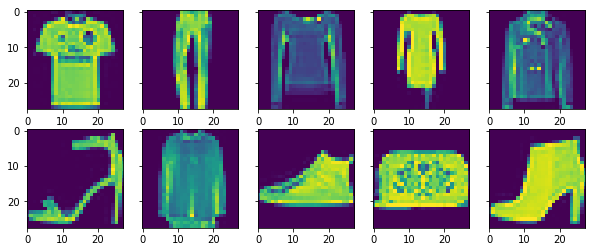

In [655]:
draw_dataset()

And this is the average of each class from the full dataset 

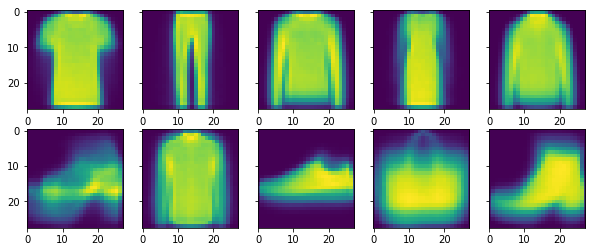

In [656]:
draw_dataset(draw_mean=True)

Here we are excluding a subset with only 4 different labels

In [657]:
data = data[data.label.isin([5,6,7,8])]
data.label -=5
X, Y = np.array(data.iloc[:, 1:]), np.array(data.label)

In [658]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y)
n_classes = len(set(y_train))
n_features = X_test.shape[1]

print("number of classes: ", n_classes)
print("number of features: ", n_features)
print("train length: ", len(X_train))
print("test length: ", len(X_test))

number of classes:  4
number of features:  784
train length:  3000
test length:  1000


### Perform stochastic gradient descent

It would be also fine to use the gradient descent on the full dataset without any stochastic part. But here we use it just to train the model faster. 

In the procedure below you should write the update step in order to make the training work. Please write your code in the indicated place.

In [659]:
def train(X_train, y_train, batch_size=50, num_epoch=1, n_classes=n_classes, step=1e-3, plot_loss=True):
    """
        Perform gradient descent and return trained weights;
        
        X_train: np.array, shape=[n_samples, n_features]
        y_train: np.array, shape=[n_samples]
        n_classes: int
        
        return: w, shape=[n_features+1, n_classes]
    """

    losses = []
    
    n_features = X_train.shape[1]
    
    # Initialize from normal distribution
    w = np.random.randn(n_features+1, n_classes)/n_features
    
    # perform gradient descent
    for epoch in range(num_epoch):
        for iter_num, (x_batch, y_batch) in enumerate(zip(np.split(X_train, batch_size), np.split(y_train, batch_size))):
            print (x_batch.shape)
            print (w.shape)
            w += -step*get_grad(w, x_batch, one_hot_encode(y_batch, n_classes))
            losses.append(loss(w, x_batch, one_hot_encode(y_batch, n_classes)))
    
    # draw learning curve 
    if plot_loss:
        plt.plot(losses)
        plt.title("Loss")
        plt.xlabel("epochs")
        plt.show()
        
    return w

In [660]:
def make_prediction(X, W):
    """
        Take X with shape [n_samples, n_features]
        return: np.array of labels with shape [n_samples]
    """
    probability_matrix = infer(W, X)
    return np.array([np.argmax(t) for t in probability_matrix])

(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(785, 4)
(60, 784)
(7

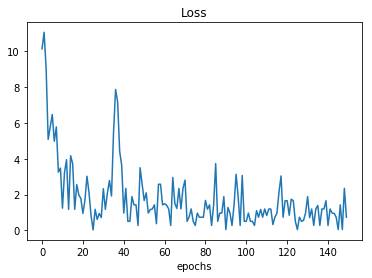

In [661]:
W = train(X_train, y_train, num_epoch=3)

## Evaluation of the results

It would be nice to get the f1-score of 0.9 or higher

In [662]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = make_prediction(X_test, W)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.78      0.87       251
          1       0.96      0.98      0.97       241
          2       0.83      0.97      0.90       243
          3       0.93      0.95      0.94       265

avg / total       0.93      0.92      0.92      1000



# Step 6

Paste your code into the google form.

It is nessesary to adhere to the requirements of the interface of the all functions you are to implement as your code will be tested automatically.

You should not use any additional libraries besides the ones already imported. All code with __import__ instructions will be automatically discarded.

### References

* Some explanations were borrowed from the [mxnet tutorial](https://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html)

* Any questions concerning the task may be sent to the e-mail: [cheskidova@phystech.edu](mailto:cheskidova@phystech.edu)